In [83]:
from FastSurfer.FastSurferCNN.data_loader.load_neuroimaging_data import load_and_conform_image
import nibabel as nib
from nibabel.processing import conform
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.decomposition import SVD

from PIL import ImageFilter
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torch.nn import CrossEntropyLoss

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import os
import random
from pathlib import Path
import joblib

from models.densenet import densenet121

ImportError: cannot import name 'SVD' from 'sklearn.decomposition' (c:\python38\lib\site-packages\sklearn\decomposition\__init__.py)

# Data Processing and Loading

In [106]:
df_info = pd.read_csv('data/info.csv')

ORDER_MAP = {'Artiodactyla':0,
 'Carnivora':1,
 'Chiroptera':2,
 'Eulipotyphla':3,
 'Hyracoidea':4,
 'Lagomorpha':5,
 'Marsupialia':6,
 'Perissodactyla':7,
 'Primates':8,
 'Rodentia':9,
 'Scandentia':10,
 'Xenarthra':11}

FAMILY_MAP = {'Bovidae': 0, # Artiodactyla
'Cervidae': 1, # Artiodactyla
'Canidae': 2, # Carnivora
'Felidae': 3, # Carnivora
'Mustelidae': 4, # Carnivora
'Giraffidae': 5, # Artiodactyla
'Pteropodidae': 6,
'Procaviidae': 7,
'Cercopithecidae': 8,
'Delphinidae': 9,
'Hyaenidae': 10,
'Ursidae': 11,
'Muridae': 12,
'Hominidae': 13}

REVERSED_FAMILY_MAP = {0: 'Bovidae',
                       1: 'Cervidae', 
                       2: 'Canidae', 
                       3: 'Felidae', 
                       4: 'Mustelidae'}

CLASSES = ['Bovidae', 'Cervidae', 'Canidae', 'Felidae', 'Mustelidae']

def normalize_image(img):
    img += abs(img.min())
    img /= img.max()
    return img

from augmentations import Crop
        
def process_raw_image(datadir, f, order, family, outputdir):
    if order.empty:
        order = df_info[df_info.Filename.str.fullmatch(f.stem[:f.stem.find('_')])].Order.drop_duplicates()
        family = df_info[df_info.Filename.str.fullmatch(f.stem[:f.stem.find('_')])].Family.drop_duplicates()
    if order.size != 1:
        print(f)
        print(order)
        return ''
    
    img = nib.load(f)
    img = img.get_fdata()
    img = np.nan_to_num(img)
    img = normalize_image(img)
    
    crop = Crop([80,80,32],"random")
    
    annotations = ""
    for i in range(20):
        joblib.dump([crop(img),order], outputdir + f'Processed/{f.stem}_{i}.joblib')
        annotations += f'{f.stem}_{i}.joblib,{ORDER_MAP[order.values[0]]},{FAMILY_MAP[family.values[0]]}\n'
    #img = img[20:100,20:100,50:82]
    #img_arr = trim(img, img != img[0,0,0])
    #print(f'{f} - {img_arr.shape}')
    #img = nib.Nifti1Image(a,affine=img.affine)
    #img = conform(img, out_shape=(256, 256, 256), ).get_fdata()
    
    #trimmed = trim(img, img != img[0,0,0])
    #print(f'{trimmed.shape}')
    
    return annotations

def process_raw_images(inputdir='MRI', datadir='data/', outputdir='data/', order=pd.Series(dtype=str), family=pd.Series(dtype=str)):
    annotations = 'filename,order,family\n'
    for f in tqdm((Path(datadir)/inputdir).iterdir()):
        annotations += process_raw_image(datadir, f, order, family, outputdir)
    with open(Path(datadir)/'labels.csv', 'w') as f:
        f.write(annotations)
        
def load_processed(datadir='data/'):
    train_loader = []
    for f in (Path(datadir)/'Processed').iterdir():
        train_loader.append(joblib.load(f))
    return train_loader

def load_raw(datadir='data/'):
    train_loader = []
    for f in (Path(datadir)/'MRI').iterdir():
        order = df_info[df_info.Filename.str.contains(f.stem[:f.stem.find('_')-1])].Order.drop_duplicates()
        if order.size > 1:
            print(order)
            continue
        img = nib.load(f).get_fdata()
        train_loader.append([img, order])
    return train_loader

def trim(arr, mask):
    bounding_box = tuple(
        slice(np.min(indexes), np.max(indexes) + 1)
        for indexes in np.where(mask))
    return arr[bounding_box]
    

In [180]:
process_raw_images('Resampled')

2it [00:00,  9.71it/s]

data\Resampled\.nii.gz
Series([], Name: Order, dtype: object)


53it [00:24,  2.13it/s]


In [168]:
process_raw_images('Resampled', datadir='f:/Data/OpenNeuro/ds004114-download/', outputdir='f:/Data/OpenNeuro/', order=pd.Series(['Rodentia']), family=pd.Series(['Muridae']))

192it [00:26,  7.31it/s]


In [146]:
process_raw_images('Resampled', datadir='f:/Data/OpenNeuro/ds004215-download/', outputdir='f:/Data/OpenNeuro/', order=pd.Series(['Primates']), family=pd.Series(['Hominidae']))

153it [00:20,  7.52it/s]


### Train Test split

In [191]:
df_info = pd.read_csv('data/labels.csv')
df_info = df_info.loc[df_info['family'].isin([0,1,2,3,4])]

In [192]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_info, test_size=0.33, random_state=42)

In [199]:
sum(df_info.family.value_counts())

800

In [193]:
train.to_csv("data/train.csv", index=False)

In [194]:
test.to_csv("data/test.csv", index=False)

In [197]:
train.family.value_counts()

0    148
1    118
2    111
3     81
4     78
Name: family, dtype: int64

In [196]:
test.family.value_counts()

0    72
1    62
2    49
4    42
3    39
Name: family, dtype: int64

In [169]:
df_info = pd.read_csv('f:/Data/OpenNeuro/labels.csv')

In [170]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_info, test_size=0.33, random_state=42)

In [171]:
train.to_csv("f:/Data/OpenNeuro/train.csv", index=False)

In [172]:
test.to_csv("f:/Data/OpenNeuro/test.csv", index=False)

## Print All Data

In [164]:
images = []
import imageio


for f in Path('f:/Data/OpenNeuro/ds004114-download/Resampled/').iterdir():
    img_arr = nib.load(f).get_fdata()
    imageio.imwrite(f'f:/Data/OpenNeuro/ds004114-download/Resampled-demo/{f.stem}.jpg', img_arr[:,:,80])

Lossy conversion from float64 to uint8. Range [0.0, 77.37989044189453]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 69.05459594726562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 93.79420471191406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 53.800376892089844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 45.77444839477539]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 69.6366958618164]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 69.24542236328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. R

In [167]:
import imageio

for f in Path('f:/Data/OpenNeuro/ds004215-download/Resampled/').iterdir():
    img_arr = nib.load(f).get_fdata()
    imageio.imwrite(f'f:/Data/OpenNeuro/ds004215-download/Resampled-demo/{f.stem}.jpg', img_arr[:,:,80])

Lossy conversion from float64 to uint8. Range [0.0, 1000.1281127929688]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 679.8075561523438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 783.9087524414062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 669.3659057617188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 645.6514282226562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 659.0673217773438]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 880.9634399414062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. 

In [186]:
import imageio

for f in Path('data/Processed/').iterdir():
    img_arr, _ = joblib.load(f)
    imageio.imwrite(f'data/Processed-demo/{f.stem}.jpg', img_arr[:,:,0])

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

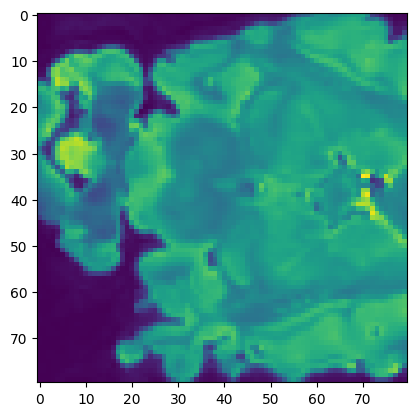

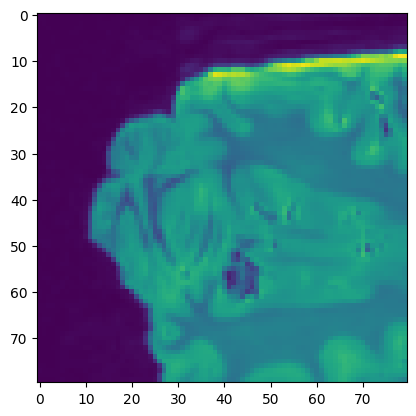

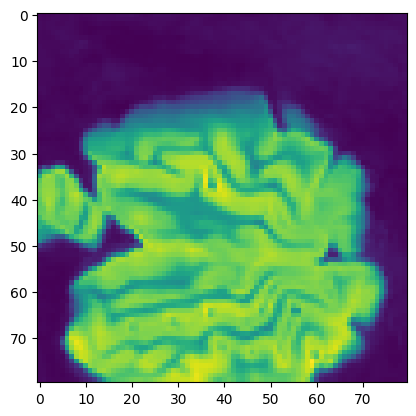

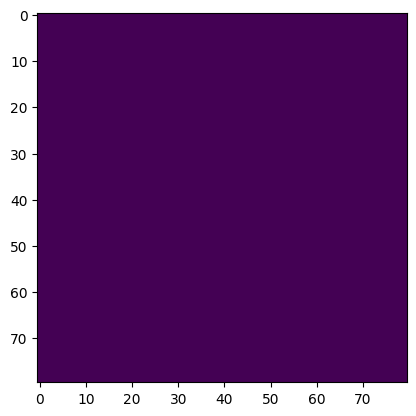

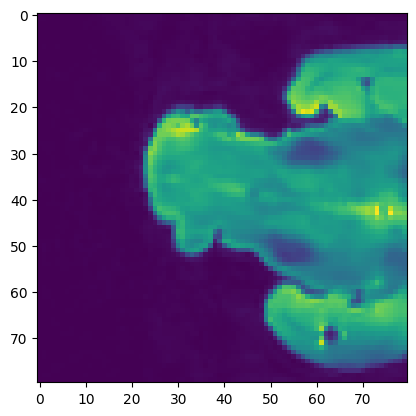

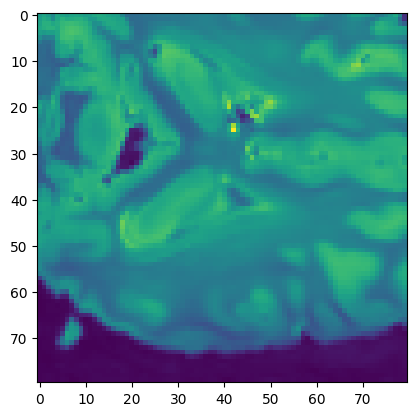

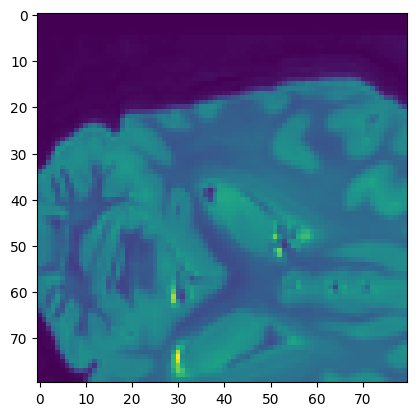

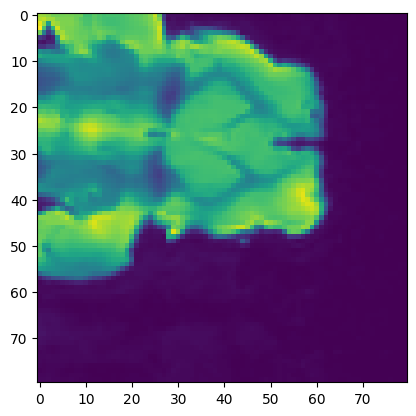

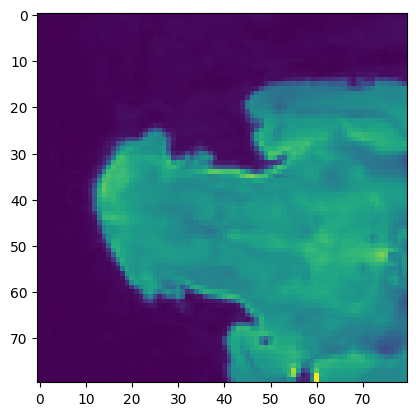

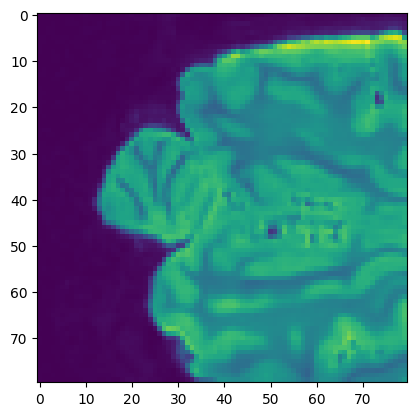

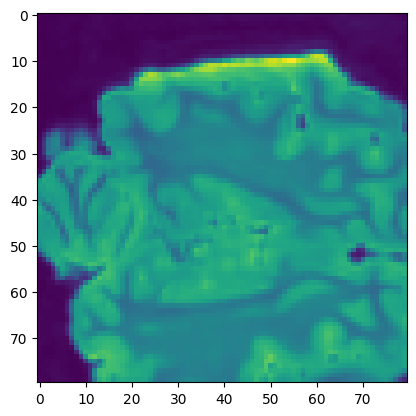

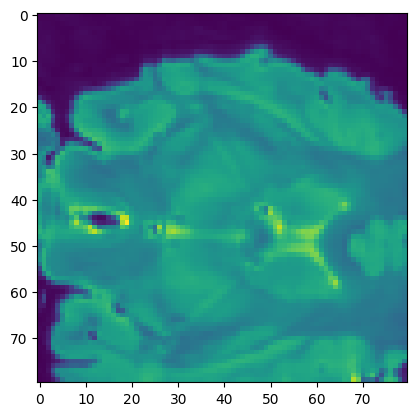

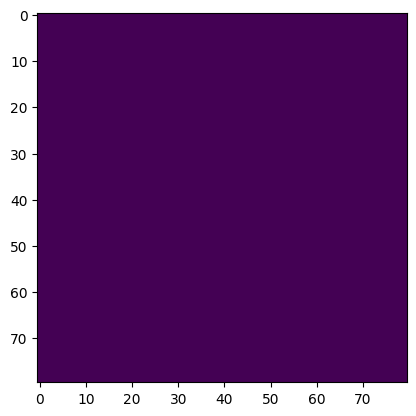

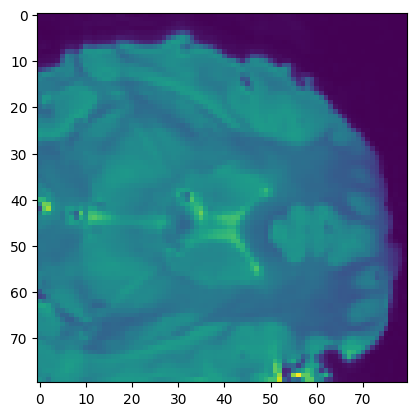

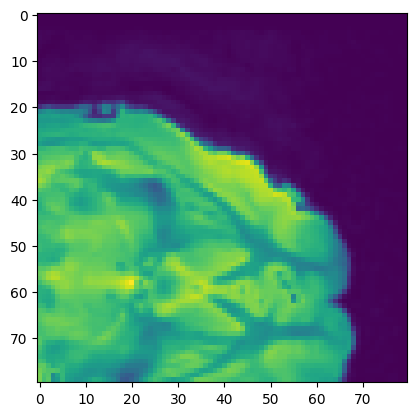

In [13]:
for img in images[:15]:
    plt.figure()
    plt.imshow(img[:,:,5])
plt.show()

In [5]:
images = []
for f in Path('data/Processed/').iterdir():
    images.append(joblib.load(f)[0])
    if len(images) > 20:
        break

# Training

## Train And Validation loss

In [42]:
model = torch.load('checkpoint/ntxent_Contrastive_MRI_epoch_50.pth')
losses = model['losses']

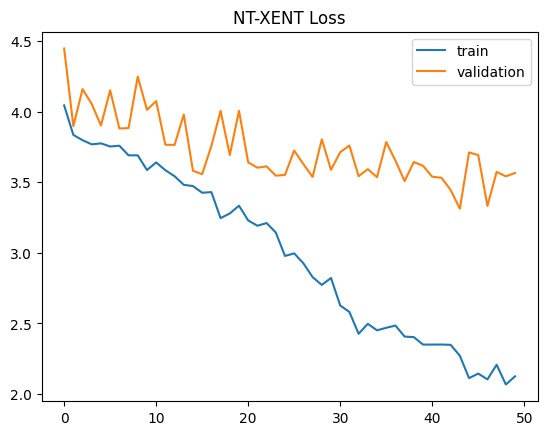

In [43]:
plt.plot(range(len(losses['train'])), losses['train'], label="train")
plt.plot(range(len(losses['validation'])), losses['validation'], label="validation")
plt.legend()
plt.title('NT-XENT Loss')
plt.show()

In [10]:
model = torch.load('checkpoint/fine_tune_epoch_100.pth')
losses = model['losses']

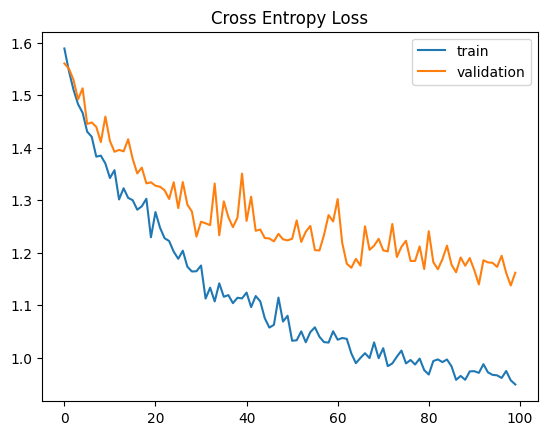

In [11]:
plt.plot(range(len(losses['train'])), losses['train'], label="train")
plt.plot(range(len(losses['validation'])), losses['validation'], label="validation")
plt.legend()
plt.title('Cross Entropy Loss')
plt.show()

In [51]:
model = torch.load('checkpoint/fine_tune_epoch_100.pth')
losses = model['losses']

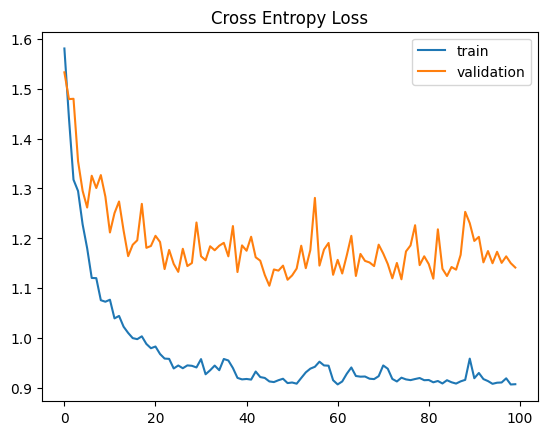

In [52]:
plt.plot(range(len(losses['train'])), losses['train'], label="train")
plt.plot(range(len(losses['validation'])), losses['validation'], label="validation")
plt.legend()
plt.title('Cross Entropy Loss')
plt.show()

In [26]:
from config import Config, PRETRAINING, FINE_TUNING
from dataset import CustomImageDataset
dataset_train = CustomImageDataset('f:/Data/OpenNeuro/train.csv', 'f:/Data/OpenNeuro/Processed/', PRETRAINING)
config = Config(PRETRAINING)
loader_train = DataLoader(dataset_train,
                              batch_size=config.batch_size,
                              sampler=RandomSampler(dataset_train),
                              pin_memory=config.pin_mem,
                              num_workers=config.num_cpu_workers
                              )

# Inference

## Get predictions

In [94]:
from dataset import CustomImageDataset
from config import Config, FINE_TUNING

config = Config(FINE_TUNING)

dataset_test = CustomImageDataset(config, 'data/test.csv', 'data/Processed/', FINE_TUNING)
loader_test = DataLoader(dataset_test,
                          batch_size=config.batch_size,
                          pin_memory=config.pin_mem,
                          num_workers=config.num_cpu_workers
                          )

dataset_unknown = CustomImageDataset(config, 'data/unknown.csv', 'data/Processed/', FINE_TUNING)
loader_unknown = DataLoader(dataset_unknown,
                          batch_size=config.batch_size,
                          pin_memory=config.pin_mem,
                          num_workers=config.num_cpu_workers
                          )

def get_predictions(net, is_encoder=False):
    y_pred = []
    y_true = []
    for inputs, labels, paths in loader_test:
        if is_encoder:
            output = net(inputs).data.cpu().numpy()
        else:
            output = torch.max(net(inputs), 1)[1].data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
    return y_pred, y_true

def get_embeddings(net, unknown=False):
    embed = []
    y_true = []
    if unknown:
        print("taking unknown data")
        loader = loader_unknown
    else:
        print("taking test data")
        loader = loader_test
            
    for inputs, labels, paths in loader:
        output = net(inputs, return_hidden=True).data.cpu().numpy()
        embed.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
    return embed, y_true

## Load the classifier and classify

In [64]:
model = torch.load('checkpoint/fine_tune_epoch_46.pth')
net = densenet121(mode="classifier", drop_rate=0.0, num_classes=5)
net = torch.nn.DataParallel(net).to('cuda')
net.load_state_dict(model['model'])
y_pred, y_true = get_predictions(net)

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint/fine_tune_epoch_46.pth'

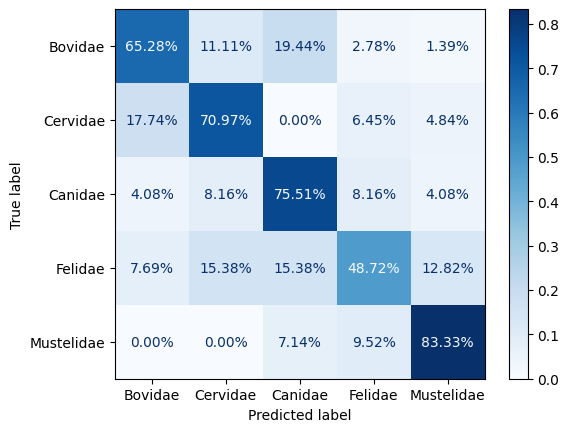

In [16]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=CLASSES, cmap='Blues', values_format='.2%', normalize='true')
plt.show()

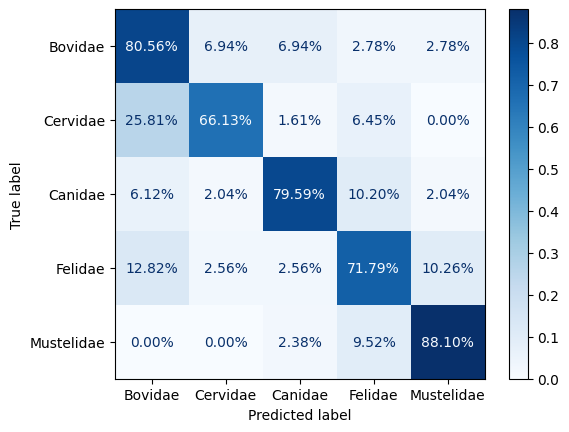

In [57]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=CLASSES, cmap='Blues', values_format='.2%', normalize='true')
plt.show()

# Latent Space Visualization

In [84]:
model = torch.load('checkpoint/fine_tune_epoch_46_5_classes_supcon.pth')
net = densenet121(mode="classifier", drop_rate=0.0, num_classes=5)
net = torch.nn.DataParallel(net).to('cuda')
net.load_state_dict(model['model'])
embed, y_true = get_embeddings(net)

In [70]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, n_iter=10000)
z = tsne.fit_transform(embed) 

c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 264 samples in 0.001s...
[t-SNE] Computed neighbors for 264 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 264 / 264
[t-SNE] Mean sigma: 9.672084
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.585228
[t-SNE] KL divergence after 950 iterations: 0.425129


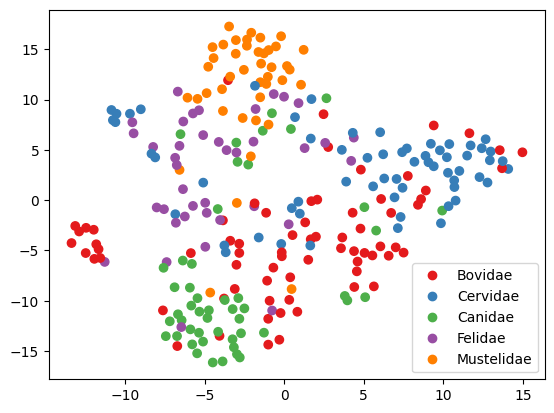

In [29]:
scatter = plt.scatter(x=z[:,0], y=z[:,1], c=y_true)
plt.legend(handles=scatter.legend_elements()[0], labels=CLASSES)
plt.show()

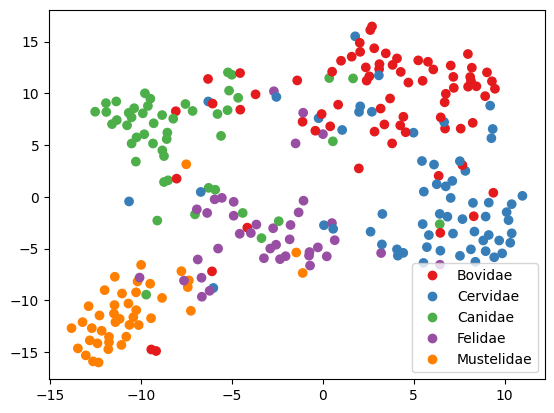

In [71]:
scatter = plt.scatter(x=z[:,0], y=z[:,1], c=y_true)
plt.legend(handles=scatter.legend_elements()[0], labels=CLASSES)
plt.show()

## Get embeddings of an unknown family

In [95]:
embed_u, y_true_u = get_embeddings(net, unknown=True)

taking unknown data


In [97]:
embed_concat = np.concatenate([embed, embed_u])
y_true_concat = np.concatenate([y_true, y_true_u])

In [98]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, n_iter=10000)
z = tsne.fit_transform(embed_concat) 

c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 324 samples in 0.000s...
[t-SNE] Computed neighbors for 324 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 324 / 324
[t-SNE] Mean sigma: 8.628436
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.194107
[t-SNE] KL divergence after 1400 iterations: 0.570530


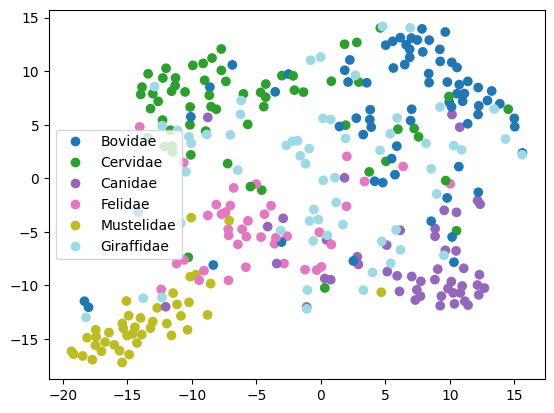

In [104]:
scatter = plt.scatter(x=z[:,0], y=z[:,1], c=y_true_concat, cmap="tab20")
plt.legend(handles=scatter.legend_elements()[0], labels=CLASSES + ['Giraffidae'])
plt.show()